# OpenRemote: Energy Transition

## Intro

### Technologies used

## Imports

In [102]:
!pip install fastai==0.7.0
!pip install pyarrow

Reason for being yanked: 0.1.2 is past it's support date and confuses users on unsupported platforms
  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\simon\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\simon\\AppData\\Local\\Temp\\pip-install-tuoue5bo\\bcolz\\setup.py'"'"'; __file__='"'"'C:\\Users\\simon\\AppData\\Local\\Temp\\pip-install-tuoue5bo\\bcolz\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\simon\AppData\Local\Temp\pip-wheel-l3s3snag'
       cwd: C:\Users\simon\AppData\Local\Temp\pip-install-tuoue5bo\bcolz\
  Complete output (42 lines):
  SSE2 detected
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\bcolz
  copying bcolz\arrayprint.py -> build\lib.win-amd64-3.8\b

    copying bcolz\__init__.py -> build\lib.win-amd64-3.8\bcolz
    creating build\lib.win-amd64-3.8\bcolz\tests
    copying bcolz\tests\all.py -> build\lib.win-amd64-3.8\bcolz\tests
    copying bcolz\tests\common.py -> build\lib.win-amd64-3.8\bcolz\tests
    copying bcolz\tests\test_attrs.py -> build\lib.win-amd64-3.8\bcolz\tests
    copying bcolz\tests\test_carray.py -> build\lib.win-amd64-3.8\bcolz\tests
    copying bcolz\tests\test_carray_objects.py -> build\lib.win-amd64-3.8\bcolz\tests
    copying bcolz\tests\test_ctable.py -> build\lib.win-amd64-3.8\bcolz\tests
    copying bcolz\tests\test_ndcarray.py -> build\lib.win-amd64-3.8\bcolz\tests
    copying bcolz\tests\test_queries.py -> build\lib.win-amd64-3.8\bcolz\tests
    copying bcolz\tests\__init__.py -> build\lib.win-amd64-3.8\bcolz\tests
    copying bcolz\carray_ext.pxd -> build\lib.win-amd64-3.8\bcolz
    running build_ext
    skipping 'bcolz\carray_ext.c' Cython extension (up-to-date)
    building 'bcolz.carray_ext' extensio


  Using cached fastai-0.7.0-py3-none-any.whl (112 kB)
  Using cached bcolz-1.2.1.tar.gz (1.5 MB)
  Using cached graphviz-0.16-py2.py3-none-any.whl (19 kB)
  Using cached ptyprocess-0.7.0-py2.py3-none-any.whl (13 kB)
  Using cached torch-0.1.2.post2.tar.gz (128 kB)
  Using cached opencv_python-4.5.2.52-cp38-cp38-win_amd64.whl (34.7 MB)
  Using cached isoweek-1.3.3-py2.py3-none-any.whl (7.1 kB)
  Using cached plotnine-0.8.0-py3-none-any.whl (4.7 MB)
  Using cached torchtext-0.9.1-cp38-cp38-win_amd64.whl (1.5 MB)
  Using cached mizani-0.7.3-py3-none-any.whl (63 kB)
  Using cached statsmodels-0.12.2-cp38-none-win_amd64.whl (9.4 MB)
  Using cached descartes-1.1.0-py3-none-any.whl (5.8 kB)
  Using cached palettable-3.3.0-py2.py3-none-any.whl (111 kB)
  Running setup.py clean for bcolz
  Running setup.py clean for torch
Failed to build bcolz torch
    Running setup.py install for bcolz: started
    Running setup.py install for bcolz: finished with status 'error'


In [224]:
import os
import warnings
import datetime as dt
import json
import requests
import sys

import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from pytz import timezone
import numpy as np

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn import metrics

from fastai.imports import *
from fastai.tabular import *

from IPython.display import display, Image

In [223]:
PATH = ".\\data\\"

In [107]:
!dir {'.'} #Windows Only Command

 Volume in drive C is System
 Volume Serial Number is E6B3-1187

 Directory of C:\Users\simon\OneDrive - PXL\School\2TINQ\_Research Project\OpenRemote-Energy-Challenge\machine-learning

08/05/2021  16:34    <DIR>          .
08/05/2021  16:34    <DIR>          ..
06/05/2021  10:57    <DIR>          .git
23/03/2021  20:33             1.948 .gitignore
06/05/2021  10:57    <DIR>          .ipynb_checkpoints
01/04/2021  19:42    <DIR>          .vscode
06/04/2021  11:01               551 api-integration.py
30/04/2021  11:35    <DIR>          data
25/03/2021  12:45            96.784 data-visualisation.ipynb
25/03/2021  12:23             2.511 data-visualisation.py
06/04/2021  11:32               488 deep-learning.py
28/03/2021  20:31            38.747 estimated_actuals.json
08/05/2021  16:34            77.325 machine-learning.ipynb
03/05/2021  20:38             1.471 machine-learning.py
06/05/2021  10:57    <DIR>          media
14/04/2021  17:52             2.896 README.md
08/05/2021  16:14   

## API Calls for datasets

In [39]:
API_URL = "https://api.openuv.io/api/v1/forecast"
API_KEY = input("API-key: ")
PREDICTION_PERIOD = 30 #Minutes
TIME_ZONE = timezone("Europe/Amsterdam")

KeyboardInterrupt: Interrupted by user

In [5]:
# OpenRemote Building Location
LAT = '51.444594'
LNG = '5.457884'
DT = '2021-02-05 01:08:59.353'

In [6]:
#http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
def get_uv_values(lat, lng, dt):
    try:
        resp = requests.get(API_URL,
            headers={"content-type":"application/json", "x-access-token": API_KEY}, 
            params={'lat': lat, 'lng': lng})
        print("Request sent to API.")
        
        if resp.status_code != 200:     # This means something went wrong
            raise requests.ConnectionError('GET openuv forecast {}'.format(resp.status_code))
        print("Response received.")
        
    except Exception as e:
        print("Could not connect to the API")
        print(str(e))
    
    rows = []
    columns = ['uv', 'uv_time', 'azimuth', 'altitude']

    for data in resp.json():
        for row in resp.json()[data]:
            new_row = [row['uv'], row['uv_time']]
            for key in row['sun_position']:
                new_row.append(row['sun_position'][key])
            rows.append(new_row)

    uv_predictions = pd.DataFrame(rows, columns=columns)
    uv_predictions['uv_time'] = pd.to_datetime(uv_predictions['uv_time'])
    uv_predictions['uv_time'] = pd.DatetimeIndex(pd.to_datetime(uv_predictions.uv_time, utc=True)).tz_convert(TIME_ZONE)
    return uv_predictions

In [7]:
uv_predictions = get_uv_values(LAT, LNG, DT)
uv_predictions

Request sent to API.
Response received.


,uv,uv_time,azimuth,altitude
0,0.0000,2021-05-08 00:58:43.421000+02:00,-1.920052,-0.011228
1,0.2747,2021-05-08 01:58:43.421000+02:00,-2.072699,0.187827
2,1.1479,2021-05-08 02:58:43.421000+02:00,-2.252322,0.369322
3,2.3350,2021-05-08 03:58:43.421000+02:00,-2.471600,0.523214
4,3.7673,2021-05-08 04:58:43.421000+02:00,-2.739627,0.635179
5,4.4737,2021-05-08 05:58:43.421000+02:00,-3.050135,0.688739
6,4.2285,2021-05-08 06:58:43.421000+02:00,2.911011,0.673229
7,3.1100,2021-05-08 07:58:43.421000+02:00,2.616968,0.591964
8,1.8346,2021-05-08 08:58:43.421000+02:00,2.371055,0.459459
9,0.6475,2021-05-08 09:58:43.421000+02:00,2.170963,0.291858


In [225]:
solar_data = pd.read_csv(f"{PATH}SolarData.csv", parse_dates=["timestamp"])

## Handy functions

In [40]:
def display_all(df):
    with pd.option_context("display.max_rows", 10000, "display.max_columns", 10000): 
        display(df)

In [109]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [118]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [121]:
def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [123]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

In [133]:
def split_vals(a,n): return a[:n], a[n:]

In [134]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [135]:
def print_score(m):
    res = {'rmse_train': rmse(m.predict(X_train), y_train), 'rmse_valid': rmse(m.predict(X_valid), y_valid),
                'r2_train': m.score(X_train, y_train), 'r2_valid': m.score(X_valid, y_valid)}
    if hasattr(m, 'oob_score_'): res['r2_oob'] = m.oob_score_
    print(res)

In [137]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [150]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

In [241]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

## Machine learning

### Variables

### Cleaning the data

In [41]:
solar_data #OpenRemote Data

,timestamp,name,attribute_name,value
0,2021-02-11 04:10:22.926,Tamar building,totalPower,0.0
1,2021-02-11 04:10:23.089,Humber building,totalPower,0.0
2,2021-02-25 04:13:48.669,Humber building,totalPower,0.0
3,2021-02-25 04:13:54.488,Tamar building,totalPower,0.0
4,2021-02-11 04:40:23.122,Tamar building,totalPower,0.0
...,...,...,...,...
5469,2021-02-25 02:43:54.267,Tamar building,totalPower,0.0
5470,2021-02-25 03:13:48.480,Humber building,totalPower,0.0
5471,2021-02-25 03:13:54.344,Tamar building,totalPower,0.0
5472,2021-02-25 03:43:48.586,Humber building,totalPower,0.0


Everything we got from the Solcast API:  
  
**Global Horizontal Irradiance** (`Ghi`) is the total solar radiation on a horizontal surface. It is the sum of DNI & DHI  
**Direct Normal Irradiance** (`Dni`) is the amount of solar radiation received per unit area by a surface that is always held in a straight line from the sun's current position  
**Diffuse Horizontal Irradiance** (`Dhi`) is the radiation at the Earth's surface from light scattered by the atmosphere.  
**Direct Beam Horizontal Irradiance** (`Ebh`) The horizontal component of DNI  
**Zenith** is the angle between the sun's rays and the vertical direction.  
**Azimuth** is the angle between the projection of sun's center onto the horizontal plane and due south direction.  
  
*10 and 90 fields represent a 10% and 90% probability bound, around a median forecast value*


In [42]:
uv_predictions # Data from openuv

,uv,uv_time,azimuth,altitude
0,0.0000,2021-05-08 00:58:43.421000+02:00,-1.920052,-0.011228
1,0.2747,2021-05-08 01:58:43.421000+02:00,-2.072699,0.187827
2,1.1479,2021-05-08 02:58:43.421000+02:00,-2.252322,0.369322
3,2.3350,2021-05-08 03:58:43.421000+02:00,-2.471600,0.523214
4,3.7673,2021-05-08 04:58:43.421000+02:00,-2.739627,0.635179
5,4.4737,2021-05-08 05:58:43.421000+02:00,-3.050135,0.688739
6,4.2285,2021-05-08 06:58:43.421000+02:00,2.911011,0.673229
7,3.1100,2021-05-08 07:58:43.421000+02:00,2.616968,0.591964
8,1.8346,2021-05-08 08:58:43.421000+02:00,2.371055,0.459459
9,0.6475,2021-05-08 09:58:43.421000+02:00,2.170963,0.291858


In [43]:
totalPower = solar_data.loc[solar_data['attribute_name'] == 'totalPower'].sort_values(by=['timestamp'], ascending=True).drop(columns=['attribute_name'])

In [44]:
totalPower

,timestamp,name,value
749,2021-02-05 01:08:59.353,Humber building,0.000000
750,2021-02-05 01:08:59.592,Tamar building,0.000000
767,2021-02-05 01:38:59.518,Humber building,0.000000
776,2021-02-05 01:38:59.678,Tamar building,0.000000
811,2021-02-05 02:08:59.722,Humber building,0.000000
...,...,...,...
3247,2021-03-08 11:16:29.019,Tamar building,12.726667
3256,2021-03-08 11:46:28.730,Humber building,2.689000
3257,2021-03-08 11:46:29.236,Tamar building,11.336000
3272,2021-03-08 12:16:28.843,Humber building,3.391500


In [45]:
humber_totalPower = totalPower.loc[totalPower['name'] == 'Humber building'].drop(columns=['name'])
tamar_totalPower = totalPower.loc[totalPower['name'] == 'Tamar building'].drop(columns=['name'])

In [46]:
tamar_totalPower, humber_totalPower

(                   timestamp      value
 750  2021-02-05 01:08:59.592   0.000000
 776  2021-02-05 01:38:59.678   0.000000
 812  2021-02-05 02:09:00.184   0.000000
 816  2021-02-05 02:39:00.276   0.000000
 839  2021-02-05 03:09:00.357   0.000000
 ...                      ...        ...
 3221 2021-03-08 10:16:28.661   6.579666
 3235 2021-03-08 10:46:28.926  11.877333
 3247 2021-03-08 11:16:29.019  12.726667
 3257 2021-03-08 11:46:29.236  11.336000
 3273 2021-03-08 12:16:29.333  15.811334
 
 [1465 rows x 2 columns],
                    timestamp     value
 749  2021-02-05 01:08:59.353  0.000000
 767  2021-02-05 01:38:59.518  0.000000
 811  2021-02-05 02:08:59.722  0.000000
 815  2021-02-05 02:38:59.931  0.000000
 840  2021-02-05 03:09:00.400  0.000000
 ...                      ...       ...
 3220 2021-03-08 10:16:27.919  1.498000
 3234 2021-03-08 10:46:28.337  2.603000
 3246 2021-03-08 11:16:28.467  2.955333
 3256 2021-03-08 11:46:28.730  2.689000
 3272 2021-03-08 12:16:28.843  3.391500


In [47]:
totalPower

,timestamp,name,value
749,2021-02-05 01:08:59.353,Humber building,0.000000
750,2021-02-05 01:08:59.592,Tamar building,0.000000
767,2021-02-05 01:38:59.518,Humber building,0.000000
776,2021-02-05 01:38:59.678,Tamar building,0.000000
811,2021-02-05 02:08:59.722,Humber building,0.000000
...,...,...,...
3247,2021-03-08 11:16:29.019,Tamar building,12.726667
3256,2021-03-08 11:46:28.730,Humber building,2.689000
3257,2021-03-08 11:46:29.236,Tamar building,11.336000
3272,2021-03-08 12:16:28.843,Humber building,3.391500


#### Setting the dataframe to the same TIME_ZONE

In [48]:
totalPower['timestamp'] = totalPower['timestamp'].dt.tz_localize(TIME_ZONE)

### Cleaned DataFrames

In [62]:
uv_predictions, totalPower

(        uv                          uv_time   azimuth  altitude
 0   0.0000 2021-05-08 00:58:43.421000+02:00 -1.920052 -0.011228
 1   0.2747 2021-05-08 01:58:43.421000+02:00 -2.072699  0.187827
 2   1.1479 2021-05-08 02:58:43.421000+02:00 -2.252322  0.369322
 3   2.3350 2021-05-08 03:58:43.421000+02:00 -2.471600  0.523214
 4   3.7673 2021-05-08 04:58:43.421000+02:00 -2.739627  0.635179
 5   4.4737 2021-05-08 05:58:43.421000+02:00 -3.050135  0.688739
 6   4.2285 2021-05-08 06:58:43.421000+02:00  2.911011  0.673229
 7   3.1100 2021-05-08 07:58:43.421000+02:00  2.616968  0.591964
 8   1.8346 2021-05-08 08:58:43.421000+02:00  2.371055  0.459459
 9   0.6475 2021-05-08 09:58:43.421000+02:00  2.170963  0.291858
 10  0.0981 2021-05-08 10:58:43.421000+02:00  2.005027  0.101583,
                             timestamp             name      value   uv  \
 0    2021-02-11 04:10:22.926000+01:00   Tamar building   0.000000  0.0   
 1    2021-02-11 04:10:23.089000+01:00  Humber building   0.000000  0

In [50]:
#Test loop
totalPower_uv = []
totalPower_azimuth = []
totalPower_altitude = []

for i, totalPower_row in totalPower.tail().iterrows():
    
    #uv_predictions = get_uv_values(LAT, LNG, '2021-03-08 11:16:29.019000')
    closest_date = min(uv_predictions.uv_time, key=lambda x: abs(x - totalPower_row.timestamp))
    closest_date_row = uv_predictions.loc[uv_predictions.uv_time == closest_date]
    
    totalPower_uv.append(closest_date_row['uv'][0])
    print('Given id', i, 'an uv value of', closest_date_row['uv'][0])
    totalPower_azimuth.append(closest_date_row['azimuth'][0])
    totalPower_altitude.append(closest_date_row['altitude'][0])
    
print(type(pd.Series(totalPower_uv, dtype='float64')[0]))
totalPower['uv'] = pd.Series(totalPower_uv, dtype='float64')
totalPower['azimuth'] = pd.Series(totalPower_azimuth, dtype='float64')
totalPower['altitude'] = pd.Series(totalPower_altitude, dtype='float64')

Given nr 3247 an uv value of 0.0
Given nr 3256 an uv value of 0.0
Given nr 3257 an uv value of 0.0
Given nr 3272 an uv value of 0.0
Given nr 3273 an uv value of 0.0
<class 'numpy.float64'>


In [78]:
if 'index' in totalPower.columns:
    totalPower = totalPower.drop(columns=['index']).reset_index().sort_values(by=['uv'])
else:
    totalPower = totalPower.sort_values(by=['uv'])

True     2934
False       5
Name: uv, dtype: int64

#### A lot of empty fields:

In [79]:
totalPower.uv.isnull().value_counts()

True     2934
False       5
Name: uv, dtype: int64

In [116]:
display_all(df_raw.isnull().sum().sort_values(ascending=False)/len(df_raw))

altitude     0.0
azimuth      0.0
uv           0.0
value        0.0
name         0.0
timestamp    0.0
dtype: float64

In [87]:
totalPower = totalPower[(totalPower.uv.isnull() == False) & (totalPower.azimuth.isnull() == False) & (totalPower.altitude.isnull() == False)]

In [88]:
display_all(totalPower)

,timestamp,name,value,uv,azimuth,altitude
0,2021-02-11 04:10:22.926000+01:00,Tamar building,0.0,0.0,-1.920052,-0.011228
1,2021-02-11 04:10:23.089000+01:00,Humber building,0.0,0.0,-1.920052,-0.011228
2,2021-02-11 04:40:23.122000+01:00,Tamar building,0.0,0.0,-1.920052,-0.011228
3,2021-02-25 04:13:48.669000+01:00,Humber building,0.0,0.0,-1.920052,-0.011228
4,2021-02-25 04:13:54.488000+01:00,Tamar building,0.0,0.0,-1.920052,-0.011228


### Pre-processing

In [196]:
os.makedirs('tmp', exist_ok=True)
try:
    totalPower.to_feather('tmp\\totalPower-raw')
except Exception as e:
        print("Could not make feather")
        print(str(e))

In [197]:
df_raw = pd.read_feather('tmp\\totalPower-raw')

In [198]:
display_all(df_raw.dtypes)

timestamp    datetime64[ns, Europe/Amsterdam]
name                                   object
value                                 float64
uv                                    float64
azimuth                               float64
altitude                              float64
dtype: object

In [199]:
train_cats(df_raw)

In [200]:
display_all(df_raw.dtypes)

timestamp    datetime64[ns, Europe/Amsterdam]
name                                 category
value                                 float64
uv                                    float64
azimuth                               float64
altitude                              float64
dtype: object

In [201]:
df_raw.name.cat.categories

Index(['Humber building', 'Tamar building'], dtype='object')

In [202]:
df, y, nas = proc_df(df_raw, 'value')

In [203]:
display_all(df.dtypes), display_all(df)

timestamp       int8
name            int8
uv           float64
azimuth      float64
altitude     float64
dtype: object

,timestamp,name,uv,azimuth,altitude
0,1,2,0.0,-1.920052,-0.011228
1,2,1,0.0,-1.920052,-0.011228
2,3,2,0.0,-1.920052,-0.011228
3,4,1,0.0,-1.920052,-0.011228
4,5,2,0.0,-1.920052,-0.011228


(None, None)

In [204]:
y

array([0., 0., 0., 0., 0.])

In [205]:
nas

{}

In [206]:
display_all(df_raw.tail())
display_all(df.tail())

,timestamp,name,value,uv,azimuth,altitude
0,2021-02-11 04:10:22.926000+01:00,Tamar building,0.0,0.0,-1.920052,-0.011228
1,2021-02-11 04:10:23.089000+01:00,Humber building,0.0,0.0,-1.920052,-0.011228
2,2021-02-11 04:40:23.122000+01:00,Tamar building,0.0,0.0,-1.920052,-0.011228
3,2021-02-25 04:13:48.669000+01:00,Humber building,0.0,0.0,-1.920052,-0.011228
4,2021-02-25 04:13:54.488000+01:00,Tamar building,0.0,0.0,-1.920052,-0.011228


,timestamp,name,uv,azimuth,altitude
0,1,2,0.0,-1.920052,-0.011228
1,2,1,0.0,-1.920052,-0.011228
2,3,2,0.0,-1.920052,-0.011228
3,4,1,0.0,-1.920052,-0.011228
4,5,2,0.0,-1.920052,-0.011228


In [217]:
model = RandomForestRegressor(n_jobs=-1)
%time model.fit(X_train, y_train)
print_score(model)

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [234]:
draw_tree(model.estimators_[0], df_trn, precision=3)

AttributeError: 'RandomForestRegressor' object has no attribute 'estimators_'

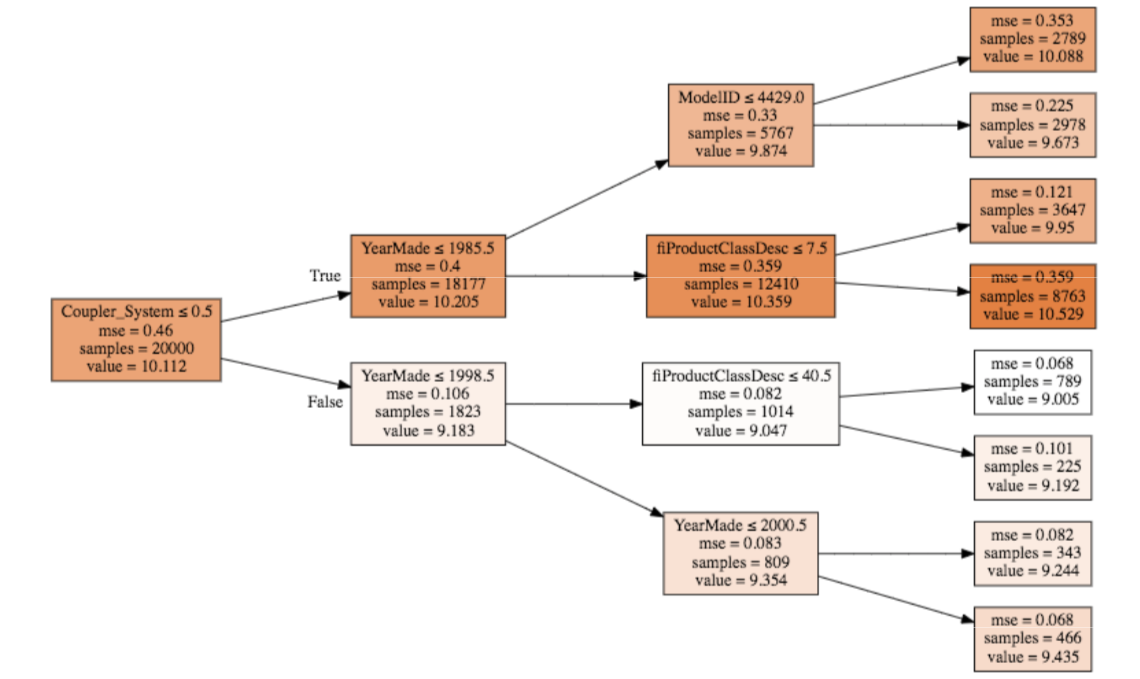

In [235]:
Image(filename=f'./media/tree.png') 

In [236]:
df_trn, y_trn, nas = proc_df(df_raw, 'value', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [237]:
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((0, 5), (0,), (5, 5), (5,))

In [214]:
model = RandomForestRegressor(n_jobs=-1)
%time model.fit(X_train, y_train)
print_score(model)

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [239]:
preds = np.stack([t.predict(X_valid) for t in model.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

AttributeError: 'RandomForestRegressor' object has no attribute 'estimators_'

In [240]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(40)]);

NameError: name 'preds' is not defined

In [ ]:
fi = rf_feat_importance(m, df_trn); fi[:30]